In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,Adam
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt


In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
X_train = train.drop('label',axis=1)
y_train = train['label']
X_test = test.copy()

# Normalize the data

X_train = X_train / 255.0
X_test  = X_test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test  = X_test.values.reshape(-1,28,28,1)


# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)


classes = np.unique(np.argmax(y_train, axis=1)).astype(str)




In [5]:
classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U21')

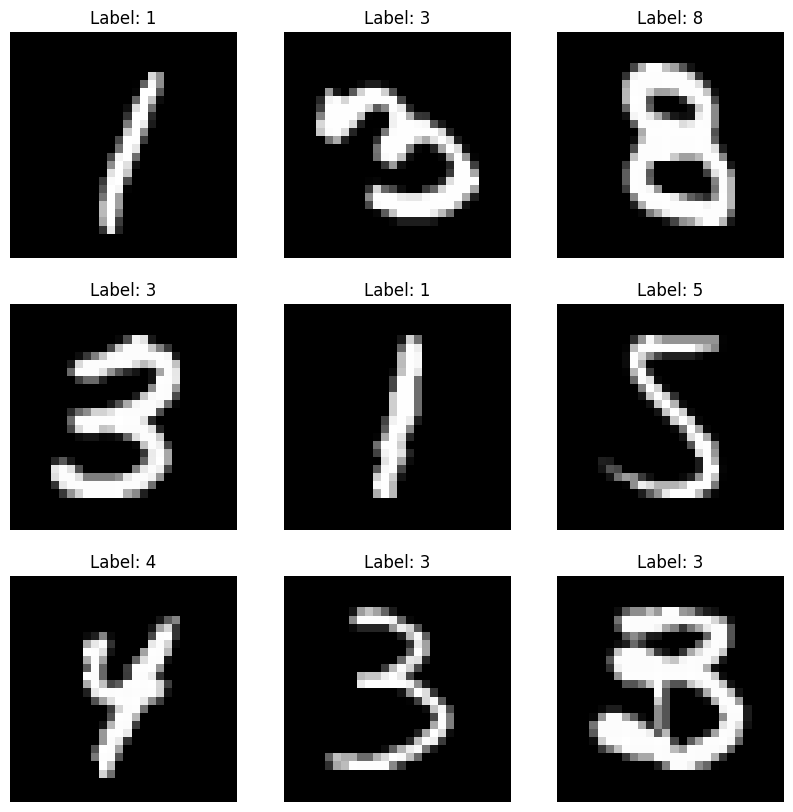

In [6]:
# plot random 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    random_index = np.random.randint(0, len(X_train))
    plt.imshow(X_train[random_index].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[random_index])}")
    plt.axis('off')
plt.show()


## Model Building

In [7]:
# Train-validation splitting
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,
                                                test_size=0.3,random_state=0)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters: 34826


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

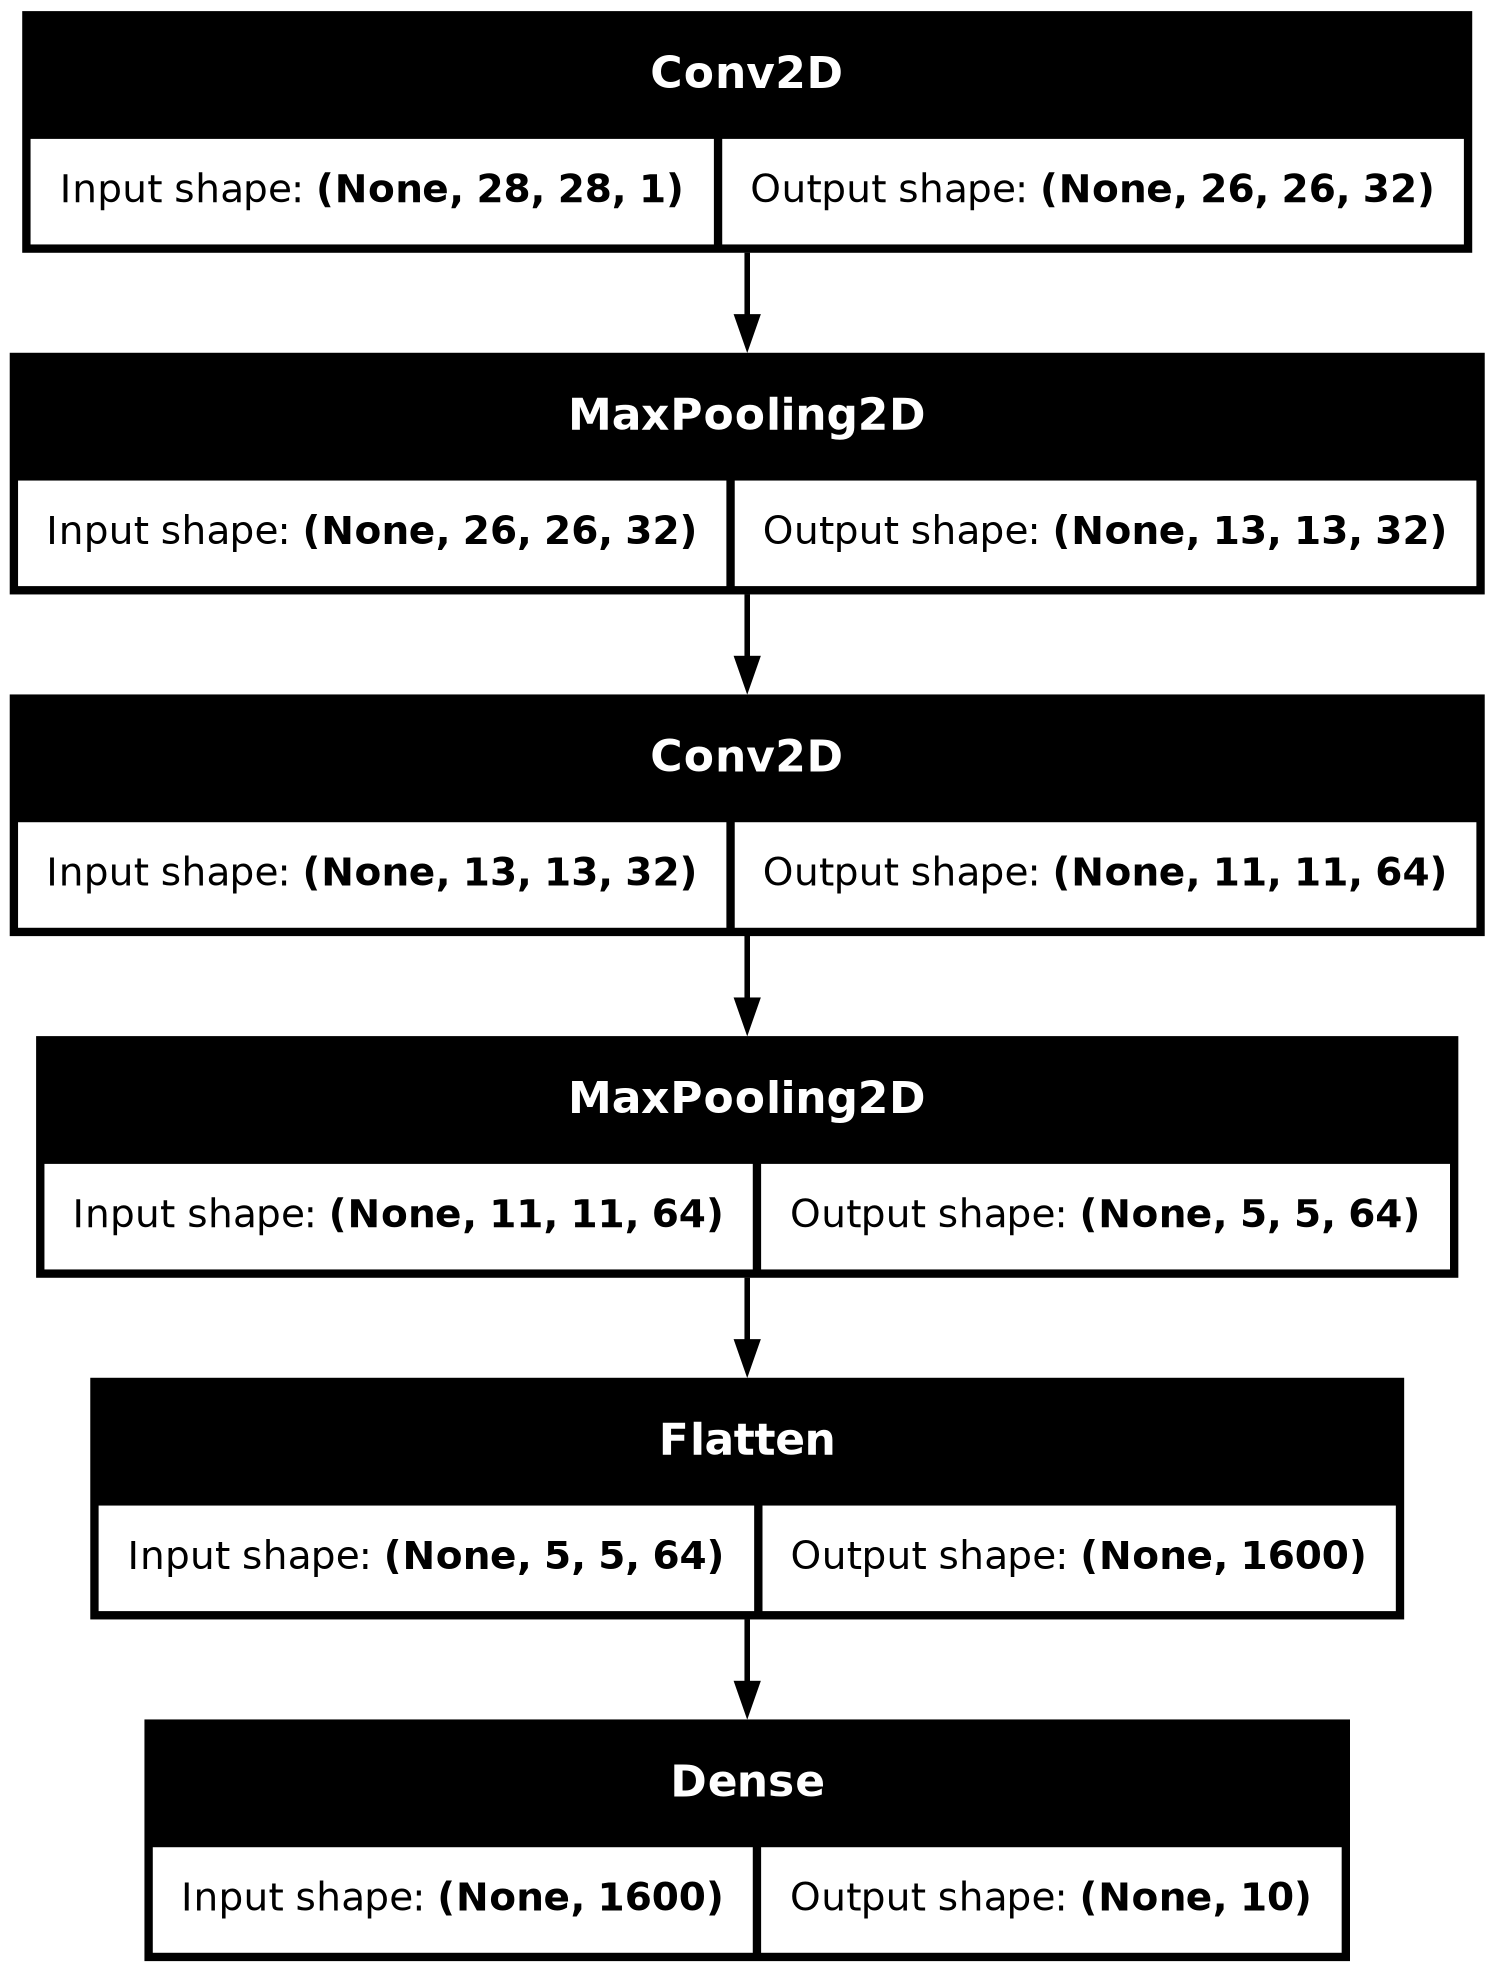

In [8]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the number of parameters
print("Number of parameters:", model.count_params())

model.summary()

# Visualize the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)







In [9]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)


Epoch 1/20


I0000 00:00:1728300307.052371      70 service.cc:145] XLA service 0x7bdfb4009d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728300307.052455      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728300307.052459      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 80/919 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5329 - loss: 1.6982

I0000 00:00:1728300309.626526      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


919/919 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8562 - loss: 0.5191 - val_accuracy: 0.9724 - val_loss: 0.0911 - learning_rate: 0.0010
Epoch 2/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9770 - loss: 0.0749 - val_accuracy: 0.9756 - val_loss: 0.0751 - learning_rate: 0.0010
Epoch 3/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9842 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 4/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9882 - loss: 0.0393 - val_accuracy: 0.9832 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 5/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9910 - loss: 0.0274 - val_accuracy: 0.9863 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 6/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9933 - loss: 0.0221 - val_accuracy: 0.9859 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 7/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9955 - loss: 0.0168 - val_accurac

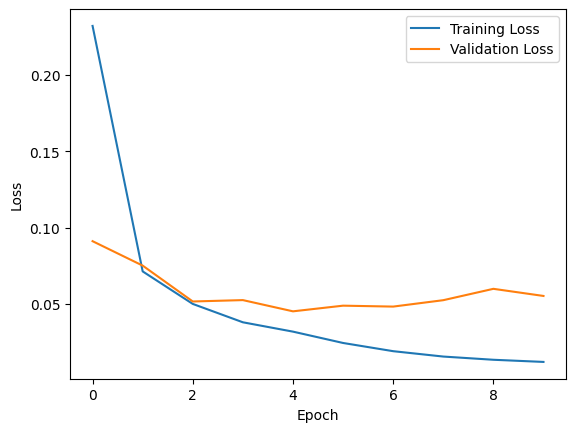

In [10]:
# Train the model
history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
X_test = np.expand_dims(X_test,-1)

# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [12]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [13]:
!head submission.csv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0
